# **WHAT MAKES AN AMAZON REVIEW HELPFUL?**

<img src='https://images.unsplash.com/photo-1523474253046-8cd2748b5fd2?q=80&w=1740&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' width='400' alt='Amazon App'>

<!-- <img src='https://images.unsplash.com/photo-1704204656144-3dd12c110dd8?q=80&w=1709&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D' width='400'  alt='Amazon Logo'>

 -->


# Introduction

### Background

In 2024, the importance of E-commerce needs no explanation: titans like Shopify and Amazon account for hundreds of billions of dollars every year, and the convenience and ubiquity of online shopping have profoundly changed the retail industry forever. While consumer reviews have been part of the retail experience since its inception, the availability and immediacy of online reviews has made this take on a life of its own in the e-commerce era, with nearly all sellers providing reviews on the store page itself. Critically, these reviews are often anonymous or pseudo-anonymous; partially as a result of this, and the financial incentives for having a well reviewed product fake reviews have become a  source of major concern for sellers. One of the methods that sellers have used to distinguish reviews apart from another is by allowing a kind of **meta-review: the helpful review**!


### Objective


Even if there is a feature on an e-commerce site to signal that a review is helpful, it may not be fully adopted by all users reading reviews. Our underlying hypothesis is that **there are helpful reviews that are not voted as 'Helpful'**. We will attempt to incover these unlabeled helpful reviews and will do so for the company **Amazon** (the world's largest online retailer as per [Forbes](https://www.forbes.com/sites/laurendebter/2022/05/12/worlds-largest-retailers-2022-amazon-walmart-alibaba/?sh=4a491ab459e3)) as it's ubiquity can provide a rich dataset and it is the market leader, pushing innnovation in the domain of this project (e.g. the AI-powered [Customers Say Review Highlights](https://www.amazon.com/gp/help/customer/display.html?nodeId=G8UYX7LALQC8V9KA))


### Assumptions

We will assume the following:
- It is in Amazon's best interest to help users in their buying decision
- Reviews are an influential step in purchase consideration, but sifting thorough them is challenging.
- For e-commerce companies that allow user feedback in qualifying reviews as "helpful", these "helpful" reviews assist users in identifying relevant reviews and could be used as input for rank ordering reviews by the company.
- There is positive business impact in improving the process, primarily by reducing customer friction that could lead to a lost sale, hence increasing **conversion rate**

# Project Scope

### Data Available

We will use a [dataset of Amazon reviews from 2023](https://amazon-reviews-2023.github.io/) produced by the [Macauley Lab at UCSD](https://cseweb.ucsd.edu/~jmcauley/). The total data consists of nearly 600M rows, so inservice of scoping the project to a feasible plan, we intend to focus on **Home and Kitchen**, with **24M records** (though we intend to use a smaller random sample, depending on compute resources), as this offers an extremely high density of data and a few assumed properties:
- The category has a wide variety of brands and similar products
- We assume this category does not result in repeat purchases of the same item as much as others, increasing importance of reviews
- As many product essential, we assume uyers will be looking for signals of quality upon purchasing, increasing importance of reviews


### Data Dictionary

User Reviews Dataset ([source](https://amazon-reviews-2023.github.io/))
- reviews (float): Rating of the product (from 1.0 to 5.0).
- title (str): Title of the user review.
- text (str): Text body of the user review.
- images (list): Images that users post after they have received the product. Each image has different sizes (small, medium, large), represented by the small_image_url, medium_image_url, and large_image_url respectively.
- asin (str): ID of the product.
- parent_asin (str): Parent ID of the product. Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually parent ID. Please use parent ID to find product meta.
- user_id (str): ID of the reviewer
- timestamp (int):Time of the review (unix time)
- verified purchase (bool): User purchase verification
- helpful_vote(int): Helpful votes of the review

### Limitations

This project has the following limitations:
- Computing resources require sampling of the data, which was already a small portion of all the Amazon review.
- Due to time and resource limitations, we need to scope down the features being considered to those available in the User Reviews data described. There may be other features for Amazon to consider including (but not limited to): user properties, product metadata, quality of images, etc
- To limit data intake we will **only consider 2023 reviews**, the most recent data available. The 2023 data to be extracted only includes reviews **up to September 2023**. We expect first 9 months are a fair representation of yearly behavior.
- As most reviews are in English, this project **will only consider reviews in English**. Hence, insights presented here should only be applied ot reviews in English.



# Initial Setup


In [1]:
# requirements.txt includes packages needed and can be modified to add new ones as needed

# !python3 -m pip install -r requirements.txt

# lines below can be used to address error in import gensim >  ImportError: cannot import name 'triu' from 'scipy.linalg'

# !python3 -m pip uninstall scipy --yes
# !python3 -m pip cache purge
# !python3 -m pip install scipy==1.12
# import scipy
# print(scipy.__version__)

In [592]:
# Data Upload

import requests
import gzip
import json
import gdown
import io
import datetime

import random
# from google.colab import files

# Data Preprocessing
from scipy.stats import norm
from langdetect import detect
from imblearn.over_sampling import RandomOverSampler

# EDA
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
# from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

# Topic Modeling
import re
import gensim
from gensim import corpora, models
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Logistic Regression
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score
import xgboost as xgb
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from xgboost import XGBClassifier



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rachelleperez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachelleperez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rachelleperez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# %%capture

# !apt install libkrb5-dev
# !wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
# !tar xf spark-3.1.2-bin-hadoop3.2.tgz
# !pip install findspark
# !pip install sparkmagic
# !pip install pyspark
# ! pip install pyspark --user
# ! pip install seaborn --user
# ! pip install plotly --user
# ! pip install imageio --user
# ! pip install folium --user

In [4]:
# import pyspark
# from pyspark.sql import SQLContext
# from pyspark.sql import SparkSession
# from pyspark.sql.types import *
# import pyspark.sql.functions as F

# spark = SparkSession.builder.getOrCreate()
# sqlContext = SQLContext(spark)

In [5]:
# %load_ext sparkmagic.magics

In [6]:
# # SQLite RDBMS
# import sqlite3

# import os
# os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Data Upload and Preview

In this section, we will:


*   Upload a sample of the reviews data
*   Preview data to confirm it looks as expected, pending closer review in next section



The data, originally sourced from [THIS SITE](https://amazon-reviews-2023.github.io/) as described above, was saved in a Google Drive folder and given public access. It can now be retrieved with [THIS LINK](https://drive.google.com/file/d/1-ImOUcxWCSgsd1w01s7DdLXl35Tr9dcl/view) which will be used below.

**NOTE:** If automated download based on the linked data does not work (could happen if file used often), save data `.gz` file (Home and Kitchen Reviews) locally in same directory. This file can be downloaded by clicking [HERE](https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Home_and_Kitchen.jsonl.gz)

In [7]:
# download from public link file using gdown
try:
  print('Attempt File Intake via GDown')
  # link for .gz file in Google Drive link: https://drive.google.com/file/d/1-ImOUcxWCSgsd1w01s7DdLXl35Tr9dcl/view?usp=sharing (shared with anyone with a link)
  file_id = '1-ImOUcxWCSgsd1w01s7DdLXl35Tr9dcl'
  url = f'https://drive.google.com/uc?id={file_id}'
  output_file = 'Home_and_Kitchen.jsonl.gz'
  gdown.download(url, output_file, quiet=False)
  print('File Intake via GDown Success')

# if you can't use web version, upload from local file
except:
  print('Unable in injest from GDown')
  output_file = '/Home_and_Kitchen.jsonl.gz' # expects local execution with file in same folder

Attempt File Intake via GDown


Downloading...
From (original): https://drive.google.com/uc?id=1-ImOUcxWCSgsd1w01s7DdLXl35Tr9dcl
From (redirected): https://drive.google.com/uc?id=1-ImOUcxWCSgsd1w01s7DdLXl35Tr9dcl&confirm=t&uuid=ca2e7c09-fb8c-4607-931a-68b15d9c9974
To: /Users/rachelleperez/Desktop/cis_545_project/Home_and_Kitchen.jsonl.gz
100%|██████████| 8.42G/8.42G [01:53<00:00, 74.2MB/s]

File Intake via GDown Success


Let's now extract the data needed. The data (in `.gz` file) just downloaded includes all the **Home and Kitchen** Amazon Reviews in the data sourced but we only want to **keep the 2023 data**.

Hence below, we will extract all the data for 2023. The date is in unix (as per the data dictionary section above). To convert it into a year, we can use the function [datetime.fromtimestamp](https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp) which expects the input in the unit seconds to turn into a date and then extract the year.

<!-- **NOTE (Limitation)**: Ingesting all 2023 reviews to then make a random sample of them would have been the best course of action, but due to RAM limitations, we will ingest only up to the sample_size desired. The code for the former will be available below for reference but commented. There is a potential risk in the data being ordered in a way that introduces bias. -->

In [8]:
# try-except-else to confirm the file downloaded is in the format expected
try:
    with gzip.open(output_file, 'rb') as f:
        f.read(1) # try to read first byte
        f.seek(0) # rewinds file pointer for next stage
except IOError:
    print(f"File '{output_file}' not in gzip format needed.")
else:
    # if reached, file in correct format, attemp data load into JSON
    json_reviews = {}
    with gzip.open(output_file, 'rb') as f: # with format, closes file upon finished
        i = 0
        for line in io.TextIOWrapper(f, encoding='utf-8'):
            json_data = json.loads(line.strip())
            # print(json_data)
            # print('timestamp' in json_reviews)

            # extract the year of the review
            if 'timestamp' in json_data:
              # extract year
              timestamp_s = json_data['timestamp'] / 1000 # converts to seconds
              review_date = datetime.datetime.fromtimestamp(timestamp_s)
              review_year = review_date.year

              # print(timestamp_s)
              # print(review_date)
              # print(review_year)

              # save 2023 year only
              if review_year == 2023:
                json_data['date'] = review_date # saved the date for future use
                json_reviews[i] = json_data
                i += 1


In [9]:
json_reviews[0]

{'rating': 1.0,
 'title': 'Received Used & scratched item! Purchased new!',
 'text': 'Livid.  Once again received an obviously used item that has food on it & scratches. I purchased this new!!  Pics not loading rn. Will add them later. Disgusted.',
 'images': [],
 'asin': 'B007WQ9YNO',
 'parent_asin': 'B09XWYG6X1',
 'user_id': 'AFKZENTNBQ7A7V7UXW5JJI6UGRYQ',
 'timestamp': 1677373409298,
 'helpful_vote': 1,
 'verified_purchase': True,
 'date': datetime.datetime(2023, 2, 25, 20, 3, 29, 298000)}

In [10]:
len(json_reviews)

3993946

**Sample Size**: This review set is way too large, so we will generate a random sample of 100,000 elements below. We picked 100K elements as we want at least 50K records after preprocessing for robust analysis and expect some dropoff along the way. For randomization, we will use Python's [random.seed](https://docs.python.org/3/library/random.html) so that upon this note's reproductions, the same elements are selected.

In [11]:
# what data size to keep?
sample_size = 100000

In [12]:
# sets the random seed described above
random.seed(5450)

In [13]:
# extract keys
json_reviews_keys = list(json_reviews.keys()) # expect range(0, len(json_reviews)-1)

In [14]:
json_reviews_keys_random = random.sample(json_reviews_keys, sample_size)

In [15]:
# new dictionary with just the sample
json_reviews_sample = {key: json_reviews[key] for key in json_reviews_keys_random }

In [16]:
len(json_reviews_sample)

100000

In [17]:
# preview an element

json_reviews_sample[list(json_reviews_sample.keys())[0]] # may no longer have key of 0 so extracting keys as a list and picking 1

{'rating': 5.0,
 'title': 'Best genshin cloak ever!!',
 'text': "I got the klee set and it was PERFECT! Nothing could be called wrong. The cloak is so sturdy and thick and fluffy and soft! The print is amazing, it fits well, and im American size 2x, so surprised it's so nice! The dodoco tales book it came with was also superior quality, and makes a cute decor or a lovely pillow, it had a very slight smell to it but it aired out overnight and is very good now.  Plus it came with a cute little vision and a klee keychain and i got a random nehida bookmark, which is holographic and also well made. Well worth the price, and it arrived earlier than expected!!",
 'images': [],
 'asin': 'B09ZGD2GLK',
 'parent_asin': 'B09ZG666VM',
 'user_id': 'AHUYIA6NT7CE3UZZJL6QZLFDUW4A',
 'timestamp': 1692302206126,
 'helpful_vote': 0,
 'verified_purchase': True,
 'date': datetime.datetime(2023, 8, 17, 15, 56, 46, 126000)}

Now, that the desired data is saved in the dictionary `json_reviews_sample`, we can format this data as a dataframe. Once the dataframe is ready, we can discard the helper dictionaries `json_reviews` and `json_reviews_sample` used in this section as they won't be needed in future sections

In [18]:
raw_reviews = pd.DataFrame.from_dict(json_reviews_sample, orient='index')
raw_reviews.reset_index(drop=True, inplace=True) # update to 0 indexing, instead of the keys in the json

# preview data
raw_reviews.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date
0,5.0,Best genshin cloak ever!!,I got the klee set and it was PERFECT! Nothing...,[],B09ZGD2GLK,B09ZG666VM,AHUYIA6NT7CE3UZZJL6QZLFDUW4A,1692302206126,0,True,2023-08-17 15:56:46.126
1,5.0,Awesome!,"Great quality, perfect packaging and beautiful...",[{'small_image_url': 'https://m.media-amazon.c...,B0B5TL3VPJ,B0C9R1K7KX,AG2YS4TLOV34BNM57IKDLV4GGUHQ,1676241778198,1,True,2023-02-12 17:42:58.198


In [19]:
# delete uneeded resources
del json_reviews
del json_reviews_sample

In [20]:
# raise Exception("Stop: End of Data Upload")

We have reached the conclusion of data input, a dataframe with the sample reviews we were looking for

# Data Preprocessing

In this section, we will proprocess our reviews dataset with checks for: **nulls, wrong data types**, and any else that may come up. This area will contain the first steps in feature engineering.


In [204]:
# input raw_reviews from data upload
# output here: reviews = a dataframe ready for EDA

# start with copying raw_reviews from section above. This new df will undergo changes
reviews = raw_reviews.copy()

In [205]:
reviews.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date
0,5.0,Best genshin cloak ever!!,I got the klee set and it was PERFECT! Nothing...,[],B09ZGD2GLK,B09ZG666VM,AHUYIA6NT7CE3UZZJL6QZLFDUW4A,1692302206126,0,True,2023-08-17 15:56:46.126
1,5.0,Awesome!,"Great quality, perfect packaging and beautiful...",[{'small_image_url': 'https://m.media-amazon.c...,B0B5TL3VPJ,B0C9R1K7KX,AG2YS4TLOV34BNM57IKDLV4GGUHQ,1676241778198,1,True,2023-02-12 17:42:58.198


Upon first glance, the data looks as expected. Let's consider nulls first

In [206]:
reviews.isnull().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
date                 0
dtype: int64

There are no nulls. Let's look at **duplicates**. As images is an array, we can't use drop_duplicates on the entire dataframe. Hence, we will base duplicate drops based on certain columns where a duplicate = the same user putting more than one review at the exact same time, down to the ms, for the exact same product.

In [207]:
# how much will stay after
duplicate_check_cols = ['user_id', 'timestamp', 'parent_asin', 'asin']
len(reviews.drop_duplicates(subset=duplicate_check_cols))

99956

In [208]:
# drop duplicates
len(reviews)

100000

In [209]:
reviews.drop_duplicates(subset=duplicate_check_cols, inplace=True)
len(reviews)


99956

We finished with duplicates. Let's look at data types now.

In [210]:
reviews.dtypes

rating                      float64
title                        object
text                         object
images                       object
asin                         object
parent_asin                  object
user_id                      object
timestamp                     int64
helpful_vote                  int64
verified_purchase              bool
date                 datetime64[ns]
dtype: object

The string columns are correctly identified, let's take a closer look at the numeric ones and boolean ones below.

In [211]:
# Rating
reviews['rating'].value_counts(normalize=True)

rating
5.0    0.638581
1.0    0.126886
4.0    0.105737
3.0    0.072642
2.0    0.056155
Name: proportion, dtype: float64

In [212]:
# change to integer as decimal is unecessary information

reviews['rating'] = reviews['rating'].astype(int)

In [213]:
reviews['rating'].dtypes

dtype('int64')

For rating, we know there are not nulls and the data will be an integer 1-5. Let's now consider the `timestamp` and `date` columns. The first can be dropped right away as it is redundant. For the latter, let's break it apart into some interesting components.

**NOTE**: As timestamp was in unix and we don't have each user's timezone, we will assume there is no way to know the individual local time. Hence, we will not use hour. Some of those differences would be slightly less marked in day of the week and month. *For `dt.dayofweek`, the days are denoted by 0-6 based on Monday-Sunday ([src](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html))*

In [214]:
# drop timestamp
len(reviews.columns)

11

In [215]:
reviews.drop(columns=['timestamp'], inplace=True)
len(reviews.columns)

10

In [216]:
# preview date
reviews['date'].head(4)

0   2023-08-17 15:56:46.126
1   2023-02-12 17:42:58.198
2   2023-01-08 19:39:47.867
3   2023-07-16 14:24:22.125
Name: date, dtype: datetime64[ns]

In [217]:
reviews['dow'] = reviews['date'].dt.dayofweek
reviews['dow'].value_counts(normalize=True)

dow
0    0.157249
1    0.149496
2    0.147485
6    0.140962
3    0.140842
5    0.133109
4    0.130858
Name: proportion, dtype: float64

In [218]:
reviews['month'] = reviews['date'].dt.month
reviews['month'].value_counts(normalize=True)

month
1    0.264726
3    0.226640
2    0.202669
4    0.126206
5    0.070161
6    0.045130
7    0.036916
8    0.025791
9    0.001761
Name: proportion, dtype: float64

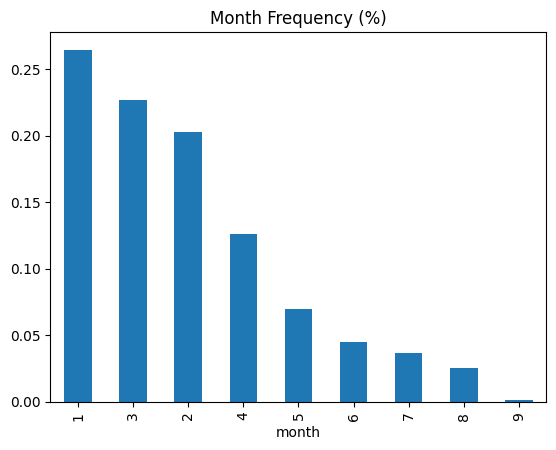

In [219]:
reviews['month'].value_counts(normalize=True).plot.bar().set_title('Month Frequency (%)');

**NOTE (Limitation):** We dont have data for all 2023. The data does not go past September 9th. We will be under the assumption the months left are representative of the patterns for the year.

In [220]:
# drop date
len(reviews.columns)

12

In [221]:
reviews.drop(columns=['date'], inplace=True)
len(reviews.columns)

11

The date was handled. We dont have a timestamp or date, but kept a days of week and a month columns for curiosity later.

Let's quicksly move on to the booleans. For EDA purposes, let's make these True/False instead of integer (to be changed later for modeling)

In [222]:
# verified purchase
reviews['verified_purchase'].value_counts(normalize=True)

verified_purchase
True     0.868662
False    0.131338
Name: proportion, dtype: float64

In [223]:
# helpful_vote
reviews['helpful_vote'].nunique()

65

In [224]:
# What is the distribution
reviews['helpful_vote'].value_counts(normalize=True).head(20)

helpful_vote
0     0.809896
1     0.119252
2     0.034355
3     0.013956
4     0.007353
5     0.004512
6     0.002741
7     0.001671
8     0.001221
9     0.000970
10    0.000650
11    0.000550
12    0.000330
13    0.000320
14    0.000280
15    0.000250
17    0.000190
19    0.000150
16    0.000150
21    0.000120
Name: proportion, dtype: float64

In [225]:
reviews['helpful_vote'].value_counts(normalize=True).head(3).sum()

0.9635039417343632

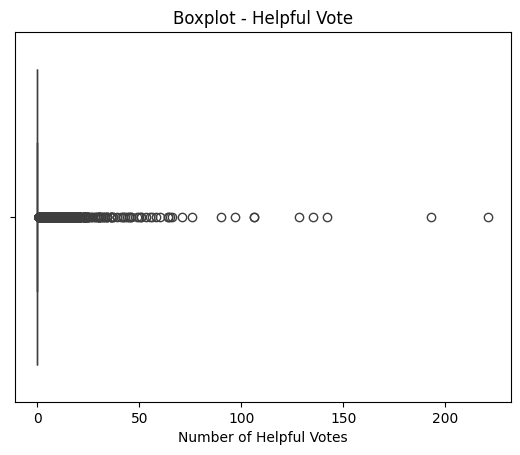

In [226]:
sns.boxplot(x=reviews['helpful_vote'])
plt.xlabel('Number of Helpful Votes')
plt.title('Boxplot - Helpful Vote');

For `helpful_vote`, it is important to note this field is highly skewed. With **~80% of reviews having 0 votes** as a helpful review and **~96% reviews having 3 or less**. We can see via the boxplot above, this data has outliers.

To improve usability, let's extract a boolean of being marked at all helpful vs and consider outliers based z-test with a 95% confidence interval.


<!-- For **extracting outliers**, we will use a simple process based on z-scores on a 95% confidence interval. -->

In [227]:
reviews['is_helpful'] = reviews['helpful_vote'] > 0
reviews['is_helpful'].value_counts(normalize=True)

is_helpful
False    0.809896
True     0.190104
Name: proportion, dtype: float64

In [228]:
# Look for outliers based on 95% confidence interval.

confidence_level = 0.95
z_score = norm.ppf((1 + confidence_level) / 2)

helpful_vote_mean = reviews['helpful_vote'].mean()
helpful_vote_std = reviews['helpful_vote'].std()

lower_bound = helpful_vote_mean - z_score * helpful_vote_std
upper_bound = helpful_vote_mean + z_score * helpful_vote_std

# identify outliers

outliers = reviews[(reviews['helpful_vote'] < lower_bound) | (reviews['helpful_vote'] > upper_bound)].index
perc_outliers = len(outliers) / len(reviews) * 100
perc_outliers

1.5186682140141663

In [229]:
len(outliers)

1518

In [230]:
# Assuming all outliers in True, how much of the True would be dropped?
len(outliers) / len(reviews.loc[reviews['is_helpful'] == True])

0.07988632775497316

Although there are outliers, we will keep them as the data is unbalanced and they are all in our minority class, corresponding to 7.5% of it.


We have extracted our possible target is_helpful. For now, we will keep is_helpful and helpful_vote for EDA but the latter must be removed before any modeling to avoid data leakage.

Now. let's get a glimpse on our string columns: title, text, images, asin, parent_asin, user_id

In [231]:
reviews['title'].head(2)

0    Best genshin cloak ever!!
1                     Awesome!
Name: title, dtype: object

In [232]:
reviews['title_length'] = reviews['title'].str.strip().str.len() # remove leading and trailing spaces before
reviews['title_length'].head(5)

0    25
1     8
2    16
3     9
4    11
Name: title_length, dtype: int64

In [233]:
# any reviews without a title once .strip() applied? No
len(reviews.loc[reviews['title_length'] == 0])

0

In [234]:
reviews['title_length'].value_counts()

title_length
12     5046
9      4669
13     4602
11     4541
10     4346
       ... 
94       31
92       31
98       29
100      28
93       27
Name: count, Length: 100, dtype: int64

In [235]:
reviews['text'].head(2)

0    I got the klee set and it was PERFECT! Nothing...
1    Great quality, perfect packaging and beautiful...
Name: text, dtype: object

In [236]:
#reviews['text_length'] = reviews['text'].str.strip().str.len() # remove leading and trailing spaces before
reviews['text_length'] = reviews['text'].str.strip().str.len() # remove leading and trailing spaces before
reviews['text_length'].head(5)

0    596
1     81
2     56
3     99
4     24
Name: text_length, dtype: int64

In [237]:
# any reviews without a text once .strip() applied? No
len(reviews.loc[reviews['text_length'] == 0])

556

In [238]:
reviews['is_blank_review'] = reviews['text_length'] == 0
reviews['is_blank_review'].value_counts(normalize=True)

is_blank_review
False    0.994438
True     0.005562
Name: proportion, dtype: float64

We have reviewed the columns for title and text. Let's consider what to do with the rest.

For user_id, let's extract a column indicating repeat reviewers but otherwise remove it.

**NOTE:** An analysis looking at the review patters of reviewers could be a great next step for this analysis.

In [239]:
# any repeat reviewers?
reviews['user_id'].nunique()

95076

In [240]:
# most users are one time reviewers, but about 9% review more than once

reviews['reviews_per_user'] = reviews.groupby('user_id')['user_id'].transform('count')
reviews['reviews_per_user'].value_counts()

reviews_per_user
1     91406
2      5762
3      1635
4       596
5       265
6       156
7        63
9        36
21       21
8        16
Name: count, dtype: int64

In [241]:
# drop user_id
len(reviews.columns)

16

In [242]:
reviews.drop(columns=['user_id'], inplace=True)
len(reviews.columns)

15

We are done with user_id. Now, what is an "ASIN". As per [Amazon's website](https://developer.amazon.com/docs/mobile-associates/mas-finding-product-id.html), an ASIN is Amazon's equivalent for a product id. For the ASIN columns, we know that each `parent_asin` value has multiple children `asin` when there are variaties of the product. Let's extract the reviews for products with reviews for different variants.

In [243]:
reviews['has_variant_reviews'] = reviews.groupby('parent_asin')['asin'].transform(lambda x: len(x.unique()) > 1)
reviews['has_variant_reviews'].value_counts(normalize=True)

has_variant_reviews
False    0.689533
True     0.310467
Name: proportion, dtype: float64

Within this project scope, we will not ingest product metadata to focus on the review features themselves. We will keep `asin` for a future section but can remove `parent_asin`

In [244]:
# drop parent_asin, asin
len(reviews.columns)

16

In [245]:
reviews.drop(columns=['parent_asin'], inplace=True)
len(reviews.columns)

15

Let's finally consider image

In [246]:
reviews['images'].head(2)

0                                                   []
1    [{'small_image_url': 'https://m.media-amazon.c...
Name: images, dtype: object

In [247]:
#images
reviews['has_image'] = reviews['images'].str.len() > 0
reviews['has_image'].value_counts(normalize=True)

has_image
False    0.851285
True     0.148715
Name: proportion, dtype: float64

In [248]:
reviews.loc[reviews['has_image'] == True]['images'].head(1)

1    [{'small_image_url': 'https://m.media-amazon.c...
Name: images, dtype: object

In [249]:
# preview
for x in reviews.loc[reviews['has_image'] == True]['images'].head(5):
  print(x)

[{'small_image_url': 'https://m.media-amazon.com/images/I/71h7PbPM5mL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/71h7PbPM5mL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/71h7PbPM5mL._SL1600_.jpg', 'attachment_type': 'IMAGE'}]
[{'small_image_url': 'https://m.media-amazon.com/images/I/71QpE7WWdQL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/71QpE7WWdQL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/71QpE7WWdQL._SL1600_.jpg', 'attachment_type': 'IMAGE'}]
[{'small_image_url': 'https://m.media-amazon.com/images/I/81BLjrj2uWL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/81BLjrj2uWL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/81BLjrj2uWL._SL1600_.jpg', 'attachment_type': 'IMAGE'}]
[{'small_image_url': 'https://m.media-amazon.com/images/I/61eC81bPpQL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/61eC81bPpQL._SL800_.jp

In [250]:
reviews['num_images'] = reviews['images'].apply(len)
reviews['num_images'].value_counts(normalize=True).head(10)


num_images
0    0.851285
1    0.089569
2    0.032664
3    0.014726
4    0.005733
5    0.002711
6    0.001381
7    0.000590
9    0.000420
8    0.000380
Name: proportion, dtype: float64

In [251]:
# reviews['images_dict'] = reviews['images'].apply(lambda lst: lst[0] if lst else {})
# reviews['images_dict']

In [252]:
# any with a value outside of image in attachment_type
reviews['has_non_image_attachment'] = reviews['images'].apply(lambda lst: any('attachment_type' in img and img['attachment_type'] != 'IMAGE' for img in lst))
reviews['has_non_image_attachment'].value_counts()

has_non_image_attachment
False    99956
Name: count, dtype: int64

In [253]:
del reviews['has_non_image_attachment']

In [254]:
# drop images
len(reviews.columns)

17

In [255]:
reviews.drop(columns=['images'], inplace=True)
len(reviews.columns)

16

In [256]:
# is has_image now redundant??? if num_images === 0 is the same, then yes
len(reviews.loc[reviews['has_image'] == False]) == len(reviews.loc[reviews['num_images'] == 0])

True

In [257]:
# drop has_image
len(reviews.columns)

16

In [258]:
reviews.drop(columns=['has_image'], inplace=True)
len(reviews.columns)

15

A big portion of our project is based on text, but we are not told the language of a given review. Hence, we will have to implement a way to detect (as accurately as possible) the **text is in English**.

Fortunately, we can leverage the existing [langdetect](https://pypi.org/project/langdetect/) library which is a "direct port of Google's [language-detection library](https://code.google.com/archive/p/language-detection/) from Java to Python".

**NOTE (Limitation)**: Insights applicable for English-language reviews only

In [259]:
def detect_english(text):
    if len(text) < 3:
        return 'N/A'
    try:
        return detect(text) == 'en'
    except:
        return 'N/A'

reviews['is_english'] = np.where(reviews['is_blank_review'], True, reviews['text'].apply(detect_english))
reviews['is_english'].value_counts(normalize=True)

is_english
True     0.945196
False    0.053514
N/A      0.001291
Name: proportion, dtype: float64

In [260]:
reviews['is_english'].value_counts()

is_english
True     94478
False     5349
N/A        129
Name: count, dtype: int64

In [261]:
# drop non-English
len(reviews)

99956

In [262]:
reviews = reviews.loc[reviews['is_english'] == True]
len(reviews)

94478

In [263]:
# drop extra is_english column no longer needed
len(reviews.columns)

16

In [264]:
reviews.drop(columns=['is_english'], inplace=True)
len(reviews.columns)

15

We were able to identify over 90% of the reviews are with some certainly in English and the rest are either not or we don't know. Non-English reviews were dropped

We have now reached the end of data preprocessing. We have checked for nulls, fixed data types, added features while removing excess info, and did a sanity check on the data seen.

In [265]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94478 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   rating               94478 non-null  int64 
 1   title                94478 non-null  object
 2   text                 94478 non-null  object
 3   asin                 94478 non-null  object
 4   helpful_vote         94478 non-null  int64 
 5   verified_purchase    94478 non-null  bool  
 6   dow                  94478 non-null  int32 
 7   month                94478 non-null  int32 
 8   is_helpful           94478 non-null  bool  
 9   title_length         94478 non-null  int64 
 10  text_length          94478 non-null  int64 
 11  is_blank_review      94478 non-null  bool  
 12  reviews_per_user     94478 non-null  int64 
 13  has_variant_reviews  94478 non-null  bool  
 14  num_images           94478 non-null  int64 
dtypes: bool(4), int32(2), int64(6), object(3)
memory usage: 8.

Save a local copy if needed


In [266]:
# create folter if needed
file_name = 'reviews_out.csv'
reviews.to_csv(file_name, index=False)

In [267]:
# raise Exception("Stop: End of Data Preprocessing")

# Exploratory Data Analysis

In [268]:
# expect a dataframe called reviews with multiple fields. end stage could include additional preprocessing based on insights
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94478 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   rating               94478 non-null  int64 
 1   title                94478 non-null  object
 2   text                 94478 non-null  object
 3   asin                 94478 non-null  object
 4   helpful_vote         94478 non-null  int64 
 5   verified_purchase    94478 non-null  bool  
 6   dow                  94478 non-null  int32 
 7   month                94478 non-null  int32 
 8   is_helpful           94478 non-null  bool  
 9   title_length         94478 non-null  int64 
 10  text_length          94478 non-null  int64 
 11  is_blank_review      94478 non-null  bool  
 12  reviews_per_user     94478 non-null  int64 
 13  has_variant_reviews  94478 non-null  bool  
 14  num_images           94478 non-null  int64 
dtypes: bool(4), int32(2), int64(6), object(3)
memory usage: 8.

In [269]:
reviews.head(2)

,rating,title,text,asin,helpful_vote,verified_purchase,dow,month,is_helpful,title_length,text_length,is_blank_review,reviews_per_user,has_variant_reviews,num_images
0,5,Best genshin cloak ever!!,I got the klee set and it was PERFECT! Nothing...,B09ZGD2GLK,0,True,3,8,False,25,596,False,1,False,0
1,5,Awesome!,"Great quality, perfect packaging and beautiful...",B0B5TL3VPJ,1,True,6,2,True,8,81,False,1,False,1


In [270]:
# TODO: add EDA

# Modeling: Introduction

We will be implementing **model stacking** where the output of text processing models will be used as input for our classifier models. 

As we build up towards the resolution in predicting if review is helpful, we will apply the following Machine Learning tools:
- Topic Modeling, using GENSIM's [Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamulticore.html) (LDA)
- Sentiment Analysis, using [TextBlob's sentiment.polarity](https://textblob.readthedocs.io/en/dev/quickstart.html)
- Logistic Regression
  - scikit-learn's [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
  - Gradient Boosting (a gradient-boosted decision tree) via [XGBoost](https://xgboost.readthedocs.io/en/stable/)

*This is in addition to applying [langdetect](https://pypi.org/project/langdetect/) to determine if a review was in English during Data Preprocessing.*

In [404]:
# base data

df = reviews.copy()

# Topic Modeling

As stated above, we will apply Topic Modeling using GENSIM's [Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamulticore.html) (LDA). Topic Modeling will output clusters of similar word groups. For each cluster identied, the LDA model will output the probabily this review belongs to the given topic (which we will use as a feature in our classifiers)

In [405]:
# expect  a dataframe called df with multiple fields including df['text'] for this section.
# for output, update df to drop text column and add topical (numerical) ones intead.

def clean_text(text):
    # Remove HTML tags

    text = str(text)

    text = re.sub(r'<[^>]+>', '', text)
    # Remove punctuation and special characters, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Lowercase the words
    tokens = [word.lower() for word in tokens]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens


reviews_txt = df['text']

processed_reviews = [clean_text(review) for review in reviews_txt]

# Create a dictionary representation of the reviews
dictionary = corpora.Dictionary(processed_reviews)

# Filter out words that appear in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=50, no_above=0.7)

# Convert the reviews to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10,workers=24)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))



Topic: 0 
Words: 0.022*"easy" + 0.015*"use" + 0.012*"great" + 0.009*"love" + 0.009*"size" + 0.008*"clean" + 0.008*"perfect" + 0.008*"would" + 0.008*"small" + 0.008*"like"
Topic: 1 
Words: 0.017*"one" + 0.012*"work" + 0.012*"use" + 0.011*"time" + 0.010*"like" + 0.010*"get" + 0.008*"well" + 0.008*"would" + 0.007*"dont" + 0.006*"water"
Topic: 2 
Words: 0.031*"great" + 0.022*"quality" + 0.018*"good" + 0.014*"product" + 0.014*"love" + 0.013*"well" + 0.012*"gift" + 0.011*"work" + 0.011*"one" + 0.011*"nice"
Topic: 3 
Words: 0.021*"love" + 0.016*"great" + 0.014*"like" + 0.013*"look" + 0.012*"color" + 0.012*"soft" + 0.009*"perfect" + 0.009*"nice" + 0.008*"really" + 0.008*"chair"
Topic: 4 
Words: 0.012*"like" + 0.011*"look" + 0.010*"one" + 0.009*"put" + 0.008*"product" + 0.007*"would" + 0.007*"together" + 0.007*"back" + 0.006*"made" + 0.006*"love"


In [406]:
# topic modeling for helpful reviews
helpful_mask = df['helpful_vote'] >=10
helpful_reviews = reviews_txt[helpful_mask]

processed_reviews = [clean_text(review) for review in helpful_reviews]

# Create a dictionary representation of the reviews
dictionary = corpora.Dictionary(processed_reviews)

# Filter out words that appear in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=50, no_above=0.7)

# Convert the reviews to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10,workers=24)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.084*"easy" + 0.069*"clean" + 0.065*"one" + 0.057*"like" + 0.052*"well" + 0.052*"enough" + 0.051*"perfect" + 0.045*"made" + 0.044*"use" + 0.041*"get"
Topic: 1 
Words: 0.086*"use" + 0.062*"great" + 0.062*"work" + 0.049*"even" + 0.048*"get" + 0.038*"well" + 0.036*"easy" + 0.036*"would" + 0.035*"need" + 0.030*"used"
Topic: 2 
Words: 0.123*"one" + 0.066*"im" + 0.062*"two" + 0.055*"ive" + 0.042*"time" + 0.034*"also" + 0.033*"year" + 0.026*"keep" + 0.026*"day" + 0.023*"could"
Topic: 3 
Words: 0.070*"thing" + 0.062*"dont" + 0.055*"make" + 0.053*"get" + 0.052*"doesnt" + 0.044*"like" + 0.041*"much" + 0.034*"would" + 0.034*"little" + 0.032*"also"
Topic: 4 
Words: 0.057*"product" + 0.056*"one" + 0.053*"would" + 0.048*"back" + 0.048*"like" + 0.038*"good" + 0.036*"put" + 0.035*"review" + 0.033*"time" + 0.032*"love"


In [407]:
# topic modeling for 1 star reviews
low_rating_mask = df['rating'] <=2

low_reviews = reviews_txt[low_rating_mask]

processed_reviews = [clean_text(review) for review in low_reviews]

# Create a dictionary representation of the reviews
dictionary = corpora.Dictionary(processed_reviews)

# Filter out words that appear in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=50, no_above=0.7)

# Convert the reviews to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10,workers=24)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.016*"like" + 0.014*"product" + 0.013*"money" + 0.013*"get" + 0.012*"one" + 0.012*"would" + 0.012*"cheap" + 0.011*"look" + 0.010*"back" + 0.009*"dont"
Topic: 1 
Words: 0.016*"return" + 0.012*"product" + 0.012*"working" + 0.012*"month" + 0.011*"one" + 0.011*"use" + 0.010*"even" + 0.010*"amazon" + 0.009*"stopped" + 0.009*"dont"
Topic: 2 
Words: 0.014*"would" + 0.014*"like" + 0.013*"small" + 0.011*"size" + 0.010*"use" + 0.008*"sheet" + 0.008*"color" + 0.008*"fit" + 0.008*"didnt" + 0.008*"one"
Topic: 3 
Words: 0.027*"time" + 0.019*"one" + 0.014*"work" + 0.013*"would" + 0.012*"like" + 0.012*"get" + 0.011*"first" + 0.011*"used" + 0.010*"bought" + 0.008*"use"
Topic: 4 
Words: 0.019*"one" + 0.013*"piece" + 0.012*"use" + 0.012*"broken" + 0.011*"water" + 0.011*"product" + 0.011*"box" + 0.010*"item" + 0.010*"came" + 0.008*"month"


In [408]:
# topic modeling for 5 star reviews
high_rating_mask = df['rating'] ==5

high_reviews = reviews_txt[high_rating_mask]

processed_reviews = [clean_text(review) for review in high_reviews]

# Create a dictionary representation of the reviews
dictionary = corpora.Dictionary(processed_reviews)

# Filter out words that appear in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=50, no_above=0.7)

# Convert the reviews to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=10,workers=24)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.026*"easy" + 0.019*"use" + 0.010*"clean" + 0.010*"one" + 0.009*"like" + 0.009*"great" + 0.009*"put" + 0.009*"well" + 0.008*"hold" + 0.008*"perfect"
Topic: 1 
Words: 0.035*"love" + 0.022*"perfect" + 0.019*"look" + 0.014*"nice" + 0.013*"like" + 0.011*"color" + 0.009*"room" + 0.009*"sturdy" + 0.009*"great" + 0.009*"easy"
Topic: 2 
Words: 0.013*"pillow" + 0.013*"love" + 0.010*"fit" + 0.009*"time" + 0.009*"one" + 0.009*"like" + 0.009*"recommend" + 0.008*"keep" + 0.008*"air" + 0.007*"use"
Topic: 3 
Words: 0.050*"great" + 0.026*"good" + 0.024*"work" + 0.021*"product" + 0.017*"quality" + 0.016*"well" + 0.014*"love" + 0.014*"easy" + 0.013*"price" + 0.012*"nice"
Topic: 4 
Words: 0.020*"one" + 0.015*"great" + 0.012*"well" + 0.012*"set" + 0.011*"would" + 0.011*"quality" + 0.011*"love" + 0.010*"bought" + 0.010*"color" + 0.009*"buy"


In [409]:
# Final Topic Modeling 

clean_reviews = df['text'].apply(clean_text)

# Create dictionary and corpus needed for Topic Modeling
dictionary = corpora.Dictionary(clean_reviews)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in clean_reviews]

# LDA Model
lda_model = models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10, workers=4)

# Getting the document-topic distribution for each document
topic_distributions = [lda_model.get_document_topics(bow) for bow in corpus]

# Convert the topic distributions to a more usable format like a DataFrame
topic_probs = []

for dist in topic_distributions:
    doc_probs = {f'topic_{i}': 0.0 for i in range(lda_model.num_topics)} 
    for topic_num, prob in dist:
        doc_probs[f'topic_{topic_num}'] = prob
    topic_probs.append(doc_probs)

topic_df = pd.DataFrame(topic_probs)

In [410]:
topic_df.describe()

,topic_0,topic_1,topic_2,topic_3,topic_4
count,94478.000000,94478.000000,94478.000000,94478.000000,94478.000000
mean,0.207467,0.161641,0.182577,0.162615,0.281083
std,0.278322,0.247731,0.254788,0.250263,0.311062
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017024,0.013654,0.015975,0.013659,0.017137
50%,0.041162,0.033417,0.040245,0.033527,0.132677
75%,0.342168,0.217259,0.283962,0.212757,0.527622
max,0.995925,0.989095,0.993107,0.992755,0.983483


In [411]:
topic_df.dtypes

topic_0    float64
topic_1    float64
topic_2    float64
topic_3    float64
topic_4    float64
dtype: object

In [412]:
# output length of topic_df
len(topic_df)

94478

In [413]:
# output length of df before changing it
len(df)

94478

In [414]:
# Merge topic modeling results back to the main dataframe (confirming sizes are the same first)
if len(df) == len(topic_df):
    df = pd.concat([df, topic_df], axis=1)
    # Fill NaN values in topic columns with 0
    df[[f'topic_{i}' for i in range(5)]] = df[[f'topic_{i}' for i in range(5)]].fillna(0.0)
else:
    raise Exception('Error in Topic Modeling')

In [415]:
df.isnull().sum()

rating                 5205
title                  5205
text                   5205
asin                   5205
helpful_vote           5205
verified_purchase      5205
dow                    5205
month                  5205
is_helpful             5205
title_length           5205
text_length            5205
is_blank_review        5205
reviews_per_user       5205
has_variant_reviews    5205
num_images             5205
topic_0                   0
topic_1                   0
topic_2                   0
topic_3                   0
topic_4                   0
dtype: int64

In [416]:
# Topic Modeling introduced extra rows where only topic_x fields are not null

nulls_in_df = df.isnull().any().any()

if nulls_in_df:
    print('Rows before dropping nulls: ', len(df))
    df.dropna(inplace=True)
    print('Rows after dropping nulls: ', len(df))

Rows before dropping nulls:  99683
Rows after dropping nulls:  94478


In [417]:
# raise Exception("End of Topic Modeling")


# Feature Engineering


In this section, we will update values in preparation for modeling
- turning booleans to integers
- turn categorical data into a numerical one
- generate additional features of interest
- add sentiment analysis
- train-test split

In addition, we will run a correlation matrix top get a glimpse of features correlated with the target.

In [418]:
# save df copy (if needed)
df_copy = df.copy()

In [499]:
# Reset opportunity
# df = df_copy

In [500]:
# output here: df = a model ready dataframe from reviews, EXCEPT it has text (as is) as it will be processed in topic modeling section

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94478 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rating               94478 non-null  float64
 1   title                94478 non-null  object 
 2   text                 94478 non-null  object 
 3   asin                 94478 non-null  object 
 4   helpful_vote         94478 non-null  float64
 5   verified_purchase    94478 non-null  int64  
 6   dow                  94478 non-null  float64
 7   month                94478 non-null  float64
 8   is_helpful           94478 non-null  int64  
 9   title_length         94478 non-null  float64
 10  text_length          94478 non-null  float64
 11  is_blank_review      94478 non-null  int64  
 12  reviews_per_user     94478 non-null  float64
 13  has_variant_reviews  94478 non-null  int64  
 14  num_images           94478 non-null  float64
 15  topic_0              94478 non-null  floa

In [501]:
# change boolean to 0,1
bool_cols = ['verified_purchase', 'is_helpful', 'has_variant_reviews', 'is_blank_review']
df[bool_cols] = df[bool_cols].astype(int)
df.dtypes


rating                 float64
title                   object
text                    object
asin                    object
helpful_vote           float64
verified_purchase        int64
dow                    float64
month                  float64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
dtype: object

Month is expressed as a number but it really is categorical data as the numbers dont have numerical value. One way to address this is by using **One-Hot Encoding** on this field.

The same applies to days of the week (`dow`). One One-Hot Encoding is done, we can drop th original columns

In [502]:
month_ohe = pd.get_dummies(df['month'], prefix='month', dtype=int).astype(int)
month_ohe.head(2)

,month_1.0,month_2.0,month_3.0,month_4.0,month_5.0,month_6.0,month_7.0,month_8.0,month_9.0
0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0


In [503]:
df = pd.concat([df, month_ohe], axis=1)
df.dtypes

rating                 float64
title                   object
text                    object
asin                    object
helpful_vote           float64
verified_purchase        int64
dow                    float64
month                  float64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
month_1.0                int64
month_2.0                int64
month_3.0                int64
month_4.0                int64
month_5.0                int64
month_6.0                int64
month_7.0                int64
month_8.0                int64
month_9.0                int64
dtype: object

In [504]:
dow_ohe = pd.get_dummies(df['dow'], prefix='dow', dtype=int).astype(int)
dow_ohe.head(2)

,dow_0.0,dow_1.0,dow_2.0,dow_3.0,dow_4.0,dow_5.0,dow_6.0
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1


In [505]:
df = pd.concat([df, dow_ohe], axis=1)
df.dtypes

rating                 float64
title                   object
text                    object
asin                    object
helpful_vote           float64
verified_purchase        int64
dow                    float64
month                  float64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
month_1.0                int64
month_2.0                int64
month_3.0                int64
month_4.0                int64
month_5.0                int64
month_6.0                int64
month_7.0                int64
month_8.0                int64
month_9.0                int64
dow_0.0                  int64
dow_1.0                  int64
dow_2.0                  int64
dow_3.0 

In [506]:
# drop month and dow
len(df.columns)

36

In [507]:
df.drop(columns=['month', 'dow'], inplace=True)
len(df.columns)

34

In the future, the feature `helpful_vote` with the number of helpful vote must be removed as it would lead to **data leakage** against the target `is_helpful`

In [508]:
df.dtypes

rating                 float64
title                   object
text                    object
asin                    object
helpful_vote           float64
verified_purchase        int64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
month_1.0                int64
month_2.0                int64
month_3.0                int64
month_4.0                int64
month_5.0                int64
month_6.0                int64
month_7.0                int64
month_8.0                int64
month_9.0                int64
dow_0.0                  int64
dow_1.0                  int64
dow_2.0                  int64
dow_3.0                  int64
dow_4.0                  int64
dow_5.0 

In [509]:
df.columns

Index(['rating', 'title', 'text', 'asin', 'helpful_vote', 'verified_purchase',
       'is_helpful', 'title_length', 'text_length', 'is_blank_review',
       'reviews_per_user', 'has_variant_reviews', 'num_images', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'month_1.0', 'month_2.0',
       'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0',
       'month_8.0', 'month_9.0', 'dow_0.0', 'dow_1.0', 'dow_2.0', 'dow_3.0',
       'dow_4.0', 'dow_5.0', 'dow_6.0'],
      dtype='object')

### Additional Features

Below are some additional features that could be helpful in determining if a review is helpful. We will use scikit-learn's [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to encode and return labels related to classification data.

In [510]:
df['product_category'] = df['asin'].apply(lambda x: x[:3])
df['brand'] = df['asin'].apply(lambda x: x[-3:])
df['exclamations'] = df['text'].apply(lambda x: x.count('!'))
df['capital_letters'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))

label_encoder = LabelEncoder()
df['product_category'] = label_encoder.fit_transform(df['product_category'])
df['brand'] = label_encoder.fit_transform(df['brand'])

In [511]:
# drop unused field moving forward
print('Cols Pre Drop: ', len(df.columns))
df.drop(columns=['asin'], inplace=True)
print('Cols Post Drop: ', len(df.columns))

Cols Pre Drop:  38
Cols Post Drop:  37


### Sentiment Analysis

Lastly, we suspect extreme views will be found more helpful. Hence, we will apply **sentiment analysis** and particularly **polarity** via the [TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html) library and in particular its's sentiment property (`sentiment.polarity`). The polarity will be a float in the range -1.0 to 1.0.

We will leverage the same `clean_text` function from Token Modeling but not it returns tokens.

In [512]:
# TextBlob Sentiment
# df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_polarity'] = df['text'].apply(clean_text).str.join(' ')
df['sentiment_polarity'] = df['sentiment_polarity'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [513]:
df['sentiment_polarity'].head(2)

0    0.188447
1    0.662500
Name: sentiment_polarity, dtype: float64

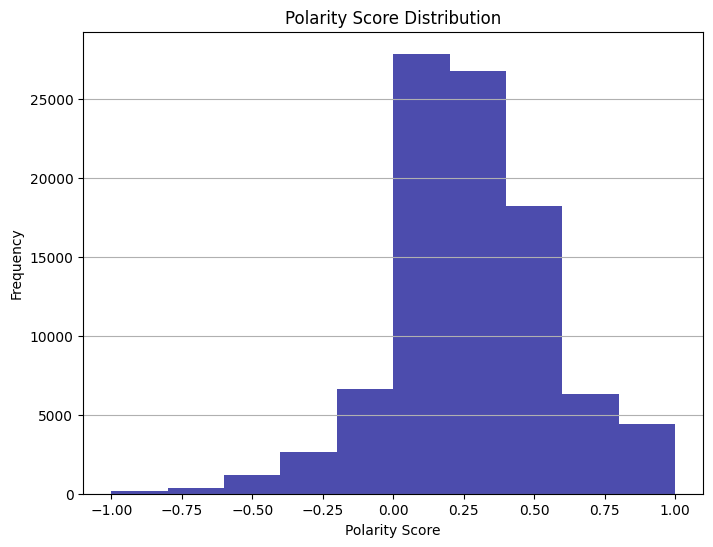

In [514]:
plt.figure(figsize=(8, 6))
plt.hist(df['sentiment_polarity'], bins=10, color='#00008B', alpha=0.7)
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Polarity Score Distribution')

plt.grid(axis='y');

In [515]:
# drop unused field moving forward
print('Cols Pre Drop: ', len(df.columns))
df.drop(columns=['title'], inplace=True)
print('Cols Post Drop: ', len(df.columns))

Cols Pre Drop:  38
Cols Post Drop:  37


From sentiment analysis, we can see reviews were determined likely be **neutral to positive**. Surprisigly, there isn't a negative peak on the negative side as expected.

### Correlation Matrix

Now that all values are numeric (except `text`), let's output a correlation matrix for the target.

We will first start by dropping `df['helpful_vote']` as that will likely lead to **data leakage**.


In [516]:
# drop redundant (leaky)
del df['helpful_vote']

In [517]:
df.dtypes

rating                 float64
text                    object
verified_purchase        int64
is_helpful               int64
title_length           float64
text_length            float64
is_blank_review          int64
reviews_per_user       float64
has_variant_reviews      int64
num_images             float64
topic_0                float64
topic_1                float64
topic_2                float64
topic_3                float64
topic_4                float64
month_1.0                int64
month_2.0                int64
month_3.0                int64
month_4.0                int64
month_5.0                int64
month_6.0                int64
month_7.0                int64
month_8.0                int64
month_9.0                int64
dow_0.0                  int64
dow_1.0                  int64
dow_2.0                  int64
dow_3.0                  int64
dow_4.0                  int64
dow_5.0                  int64
dow_6.0                  int64
product_category         int64
brand   

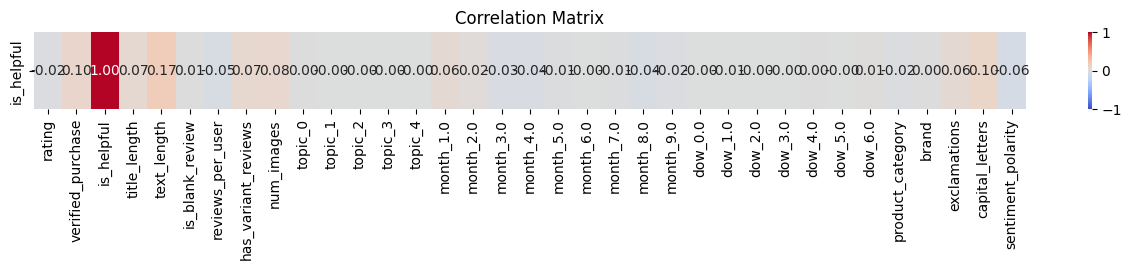

''

In [518]:
# output correlation matrix

corr = df.drop('text', axis=1).corr() # exclude 'text'
corr_row = corr.loc[['is_helpful']]

plt.figure(figsize=(16, 1))
sns.heatmap(corr_row, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
;

By using a correlation matrix, no feature seens to have a  strong correlation with the target.

### Test-Train Split and Handling Imbalance

Now, we must address our **imbalance issue** identified early on (shown below). We will proceed by **upsampling** the minority class. Any subtler imbalanced will also be addressed via the `class_weight` parameters in the Regression section below.

We will also apply scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to normalize our features in preparation for Machine Learning.


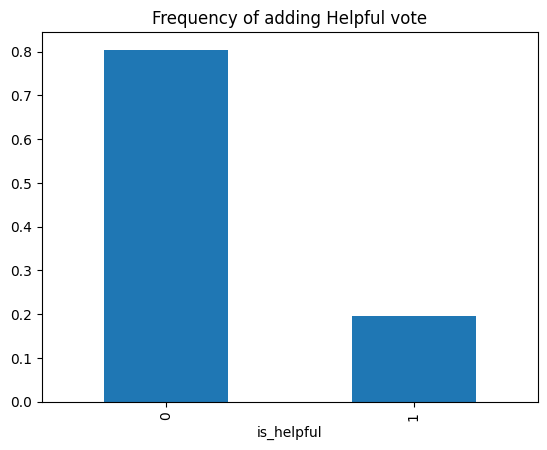

In [519]:
df['is_helpful'].value_counts(normalize=True).plot.bar().set_title('Frequency of adding Helpful vote');

In [520]:
# Feature set preparation - features  drop target and text

X = df.drop(['is_helpful', 'text'], axis=1)
y = df['is_helpful']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=5450)

In [535]:
# version with Text - features only drop target. Adding txt suffix. In this version, features are not scaled

X_txt = df.drop('is_helpful', axis=1)

X_resampled_txt, y_resampled_txt = ros.fit_resample(X_txt, y)

X_train_txt, X_test_txt, y_train_txt, y_test_txt = train_test_split(X_resampled_txt, y_resampled_txt, test_size=0.2, random_state=5450) # expect same as above due to seed

We have reached the end of this section as our main dataframe is ready for modeling, outside text processing which will be done in the next sections.

At this point, we've extracted some possible features.

In [527]:
# save df copy (if needed)
df_copy2 = df.copy()

In [528]:
# raise Exception("End of Feature Engineering Section")

# Logistic Regression Modeling

Below, we will try a sequence of classifiers to form a perspective on which might be a better approach in the challenge on predicting if a review will be voted as helpful at least once

For **hyperparameter tuning**, we will leverage scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which uses a cross-validated grid-search over a parameter grid based on user input. The inputted parameters to consider will be in the `parameters` map for each model while `.best_params_` property of each model will return the best parameters from the selection.

## Model Training


In [600]:
# EVALUATION FUNCTION 

def evaluate_model(model_name, model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    
    fig, ax = plt.subplots()
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}
    
        pred_proba = model.predict_proba(features)[:, 1]
             
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # ROC  
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve: ' + model_name)
        
        pred_target = model.predict(features)
        accuracy = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['Accuracy'] = accuracy

    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=('ROC AUC', 'Accuracy'))
    
    print(df_eval_stats)
    print()

    print('Confusion Matrix:')
    print(confusion_matrix(test_target, model.predict(test_features)))

    print('Classification Report:')
    print(classification_report(test_target, model.predict(test_features)))
    
    return model_name, round(roc_auc, 2), round(accuracy, 2)

### Dummy Classiffier

We start with a dummy classifier (scikit-learn's [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)) as a sanity check, expecting every model should do better. With `strategy` as `most_frequent`, this classifier is just retuning the most frequent value across all. In other words, it will likely always "predict" the target is negative, as it's the majority class.

In [529]:
%%time

dummy = DummyClassifier(random_state = 5450)

#paremeters for GridSearch 
parameters = {'strategy': ('most_frequent', 'stratified', 'uniform', 'prior')}
dummy = GridSearchCV(estimator=dummy, param_grid=parameters, scoring='roc_auc')

dummy.fit(X_train, y_train)

CPU times: user 226 ms, sys: 34.2 ms, total: 260 ms
Wall time: 271 ms


GridSearchCV(estimator=DummyClassifier(random_state=5450),
             param_grid={'strategy': ('most_frequent', 'stratified', 'uniform',
                                      'prior')},
             scoring='roc_auc')

In [530]:
#best params
dummy.best_params_

{'strategy': 'most_frequent'}

          train  test
ROC AUC     0.5   0.5
Accuracy    0.5   0.5

Confusion Matrix:
[[15105     0]
 [15285     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66     15105
           1       0.00      0.00      0.00     15285

    accuracy                           0.50     30390
   macro avg       0.25      0.50      0.33     30390
weighted avg       0.25      0.50      0.33     30390



/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

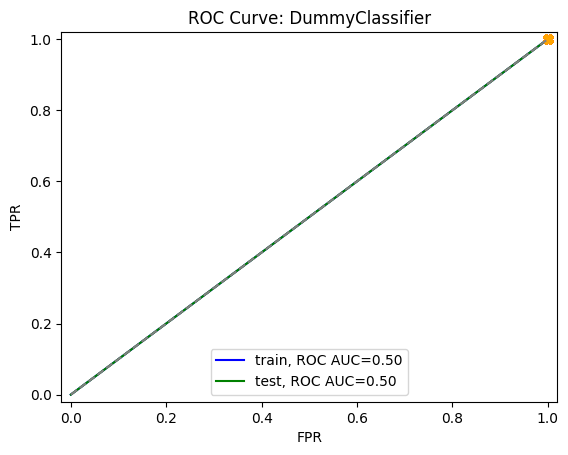

In [601]:
dummy_metrics = evaluate_model("DummyClassifier", dummy, X_train, y_train, X_test, y_test)

### Logistic Regression (Stand-alone)

Let's start with the go-to classifier for this type of task: scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [531]:
%%time

logreg = LogisticRegression(random_state=5450, class_weight='balanced')

# parameters for GridSearch (refer to documentation for allowed penalty+solver combinations) 
parameters = {'max_iter': [50, 100, 200], # default 100
                'solver': ('newton-cg', 'lbfgs', 'sag'), # lbfgs default | if resource intensive, remove newton-cg as it's more resource intensive
                'penalty': (None, 'l2' ) # l2 default
             }

logreg = GridSearchCV(estimator=logreg, param_grid=parameters, scoring='roc_auc')
logreg.fit(X_train, y_train)

CPU times: user 2min 10s, sys: 1min 14s, total: 3min 25s
Wall time: 29.9 s


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5450),
             param_grid={'max_iter': [50, 100, 200], 'penalty': (None, 'l2'),
                         'solver': ('newton-cg', 'lbfgs', 'sag')},
             scoring='roc_auc')

In [551]:
#best params
logreg.best_params_

{'max_iter': 50, 'penalty': None, 'solver': 'lbfgs'}

          train  test
ROC AUC    0.69  0.69
Accuracy   0.64  0.64

Confusion Matrix:
[[10124  4981]
 [ 5973  9312]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     15105
           1       0.65      0.61      0.63     15285

    accuracy                           0.64     30390
   macro avg       0.64      0.64      0.64     30390
weighted avg       0.64      0.64      0.64     30390



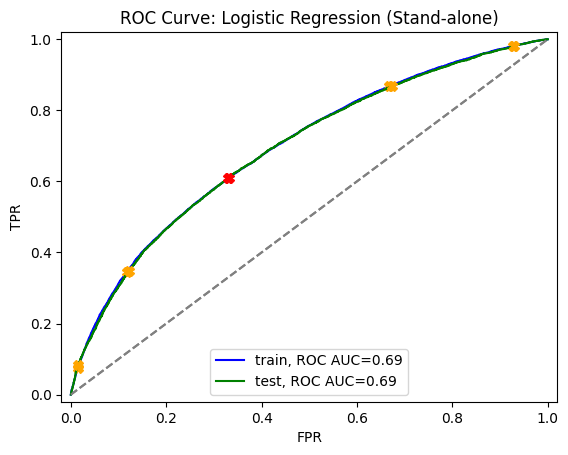

In [602]:
logreg_metrics = evaluate_model("Logistic Regression (Stand-alone)", logreg, X_train, y_train, X_test, y_test)

### Logistic Regression (Pipeline)

For the model below, we will do a veriation that processes the data differently: 
- Using scikit-learn's [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply scikit-learn's [StandardSaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) scaling only to numerical features and scikit-learn's [TdidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to text. 
- Create a Pipeline with the Preprocessing from above and the classifier, which will still be the scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

*This model has a non-numeric feature so we will use the test data with suffix `_txt` denoting it includes the `text` column and it's unscaled.*

In [539]:
df.columns

Index(['rating', 'text', 'verified_purchase', 'is_helpful', 'title_length',
       'text_length', 'is_blank_review', 'reviews_per_user',
       'has_variant_reviews', 'num_images', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'month_1.0', 'month_2.0', 'month_3.0',
       'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0',
       'month_9.0', 'dow_0.0', 'dow_1.0', 'dow_2.0', 'dow_3.0', 'dow_4.0',
       'dow_5.0', 'dow_6.0', 'product_category', 'brand', 'exclamations',
       'capital_letters', 'sentiment_polarity'],
      dtype='object')

In [541]:
# Text feature extraction
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Preprocessing for numeric features
numeric_features = [col for col in df.columns if col not in ['text', 'is_helpful']] # all columns except 'text'
numeric_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('txt', tfidf, 'text')
    ])

In [548]:
# skipping tuning
# logreg_pipe = LogisticRegression(random_state=5450, class_weight='balanced')

# # same as section above
# parameters = {'max_iter': [1000, 2000], # default 100 | warnings to "Increase the number of iterations (max_iter)"
#                 'solver': ('lbfgs', 'sag'), # lbfgs default | if resource intensive, remove newton-cg as it's more resource intensive
#                 'penalty': (None, 'l2' ) # l2 default
#              }

# logreg_pipe = GridSearchCV(estimator=logreg_pipe, param_grid=parameters, scoring='roc_auc')

# Create a pipeline with preprocessing and the classifier
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Fit the model
clf.fit(X_train_txt, y_train_txt)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['rating',
                                                   'verified_purchase',
                                                   'title_length',
                                                   'text_length',
                                                   'is_blank_review',
                                                   'reviews_per_user',
                                                   'has_variant_reviews',
                                                   'num_images', 'topic_0',
                                                   'topic_1', 'topic_2',
                                                   'topic_3', 'topic_4',
                                                   'month_1.0', 'month_2.0',
                                                   'month_3.0', 'month_4.0',
                                                   'month_5.0', 'month_6.0',
                                                   'month_7.0', 'month_8.0',
                                                   'month_9.0', 'dow_0.0',
                                                   'dow_1.0', 'dow_2.0',
                                                   'dow_3.0', 'dow_4.0',
                                                   'dow_5.0', 'dow_6.0',
                                                   'product_category', ...]),
                                                 ('txt',
                                                  TfidfVectorizer(max_features=5000,
                                                                  stop_words='english'),
                                                  'text')])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

          train  test
ROC AUC    0.77  0.74
Accuracy   0.70  0.67

Confusion Matrix:
[[10263  4842]
 [ 5067 10218]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67     15105
           1       0.68      0.67      0.67     15285

    accuracy                           0.67     30390
   macro avg       0.67      0.67      0.67     30390
weighted avg       0.67      0.67      0.67     30390



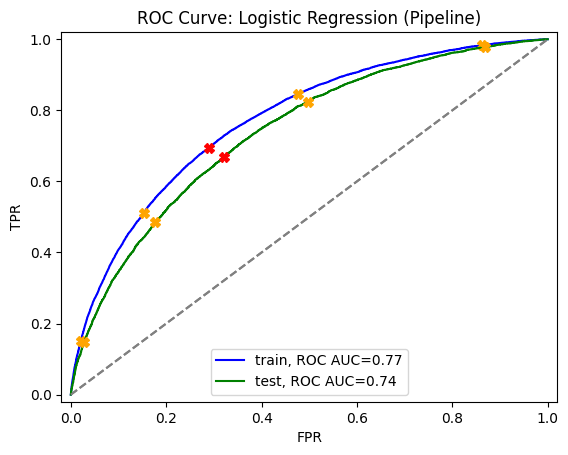

In [603]:
clf_metrics = evaluate_model("Logistic Regression (Pipeline)", clf, X_train_txt, y_train_txt, X_test_txt, y_test_txt)

### Random Forest

We will use a decision tree via a scikit-learn's [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [550]:
%%time

rforest = RandomForestClassifier(random_state=5450, class_weight='balanced')

# parameters for GridSearch (refer to documentation for allowed penalty+solver combinations) 
parameters = {
             'n_estimators': [10, 30, 50], # default: 100
              'max_depth': [1, 2, 3], # default: None
              'criterion':['gini','entropy'], # default: gini
              'max_features':['auto','sqrt', 'log2'], # default: 'auto'
              'min_samples_leaf': [1, 2], # default: 1
              'min_samples_split': [2, 5] # default: 2
              } 

rforest = GridSearchCV(estimator=rforest, param_grid=parameters, scoring='roc_auc')
rforest.fit(X_train, y_train)

/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
360 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/rachelleperez/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 666, in _validate_pa

CPU times: user 10min 7s, sys: 9.2 s, total: 10min 16s
Wall time: 10min 37s


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=5450),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 30, 50]},
             scoring='roc_auc')

In [552]:
#best params
rforest.best_params_


{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

          train  test
ROC AUC    0.69  0.69
Accuracy   0.64  0.63

Confusion Matrix:
[[9486 5619]
 [5478 9807]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     15105
           1       0.64      0.64      0.64     15285

    accuracy                           0.63     30390
   macro avg       0.63      0.63      0.63     30390
weighted avg       0.63      0.63      0.63     30390



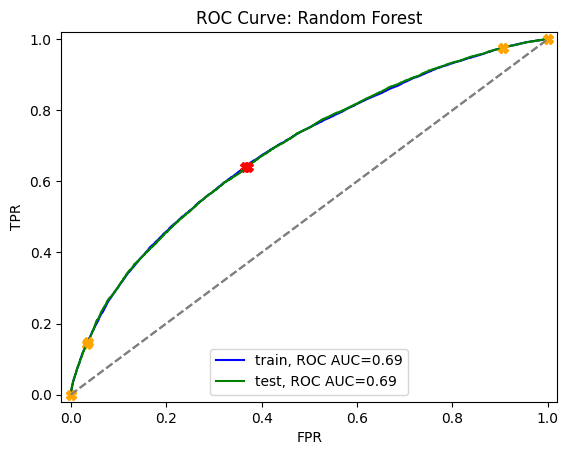

In [604]:
rforest_metrics = evaluate_model("Random Forest", rforest, X_train, y_train, X_test, y_test)

### XGBoost

Out last model, [XGBoost](https://xgboost.readthedocs.io/en/stable/), will be a gradient boosting one. Classifier documentation [HERE](https://xgboost.readthedocs.io/en/stable/python/python_api.html).

In [597]:
%%time

xg = XGBClassifier(objective='binary:logistic', max_depth=6, alpha=10, learning_rate=0.01, n_estimators=100)

# parameters for GridSearch (refer to documentation for allowed penalty+solver combinations) 
parameters = {
    'max_depth': [3, 6],  #Default: 6 
    'alpha': [0, 0.1],  # Default: 0 
    'learning_rate': [0.01, 0.1], # Default: 0.3 | step size shrinkage used in update to prevent overfitting
    'n_estimators': [50, 100],  #  # Default: 100 | boosting rounds
              } 

xg = GridSearchCV(estimator=xg, param_grid=parameters, scoring='roc_auc')
xg.fit(X_train, y_train)

CPU times: user 2min 26s, sys: 1min 11s, total: 3min 37s
Wall time: 19.5 s


GridSearchCV(estimator=XGBClassifier(alpha=10, base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0...ne,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=6,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'alpha': [0, 0.1], 'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 6], 'n_estimators': [50, 100]},
             scoring='roc_auc')

In [598]:
xg.best_params_

{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}

          train  test
ROC AUC    0.78  0.75
Accuracy   0.70  0.68

Confusion Matrix:
[[10470  4635]
 [ 4948 10337]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69     15105
           1       0.69      0.68      0.68     15285

    accuracy                           0.68     30390
   macro avg       0.68      0.68      0.68     30390
weighted avg       0.68      0.68      0.68     30390



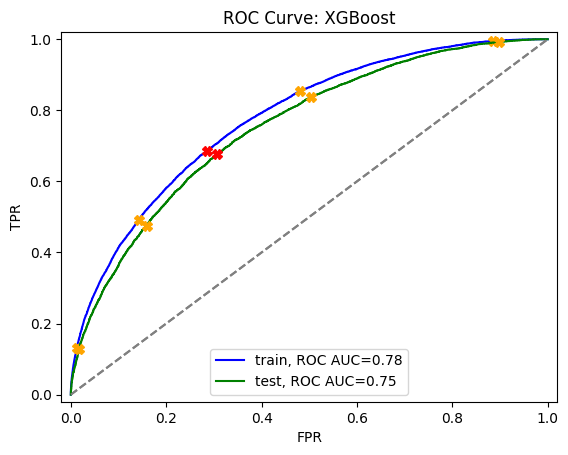

In [605]:
xg_metrics = evaluate_model("XGBoost", xg, X_train, y_train, X_test, y_test)

In [607]:
# Original XGBoost - opted for wrapped
# # import xgboost as xgb
# # from sklearn.metrics import f1_score, roc_auc_score

# # Assuming 'df' is your DataFrame and you've already processed 'text' and other columns
# X = df[['rating', 'verified_purchase', 'has_image']]
# y = df['is_helpful']

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the DMatrix
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# # Set up parameters for XGBoost
# params = {
#     'objective': 'binary:logistic',
#     'max_depth': 6,
#     'alpha': 10,
#     'learning_rate': 0.01,
#     'n_estimators': 100,
#     'eval_metric': 'auc'
# }

# # Adjusting the scale_pos_weight
# scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
# params['scale_pos_weight'] = scale_pos_weight

# # Train the model
# bst = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'test')], early_stopping_rounds=10)

# y_pred_prob = bst.predict(dtest)

# # Find the optimal threshold
# thresholds = np.linspace(0.01, 0.99, 100)
# scores = [f1_score(y_test, y_pred_prob > thresh) for thresh in thresholds]
# optimal_idx = np.argmax(scores)
# optimal_threshold = thresholds[optimal_idx]

# # Predict with the optimal threshold
# y_pred = (y_pred_prob > optimal_threshold).astype(int)

# # Calculate accuracy and other metrics
# accuracy = accuracy_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred)

# print(f'Accuracy: {accuracy}')
# print(f'ROC AUC: {roc_auc}')
# print('Confusion Matrix:')
# print(conf_matrix)
# print('Classification Report:')
# print(class_report)


## Model Evaluation

So which of the models above was best? 

In [619]:
test_results = []

for results in [dummy_metrics, logreg_metrics, clf_metrics, rforest_metrics, xg_metrics]:
    test_results.append(results)

columns = ['name', 'roc_auc', 'accuracy']
test_results_df = pd.DataFrame(test_results,columns=columns)
# test_results_df['roc_auc_rank'] = test_results_df['roc_auc'].rank(ascending=False, method='min').astype('int32')
test_results_df

,name,roc_auc,accuracy
0,DummyClassifier,0.50,0.50
1,Logistic Regression (Stand-alone),0.69,0.64
2,Logistic Regression (Pipeline),0.74,0.67
3,Random Forest,0.69,0.63
4,XGBoost,0.75,0.68


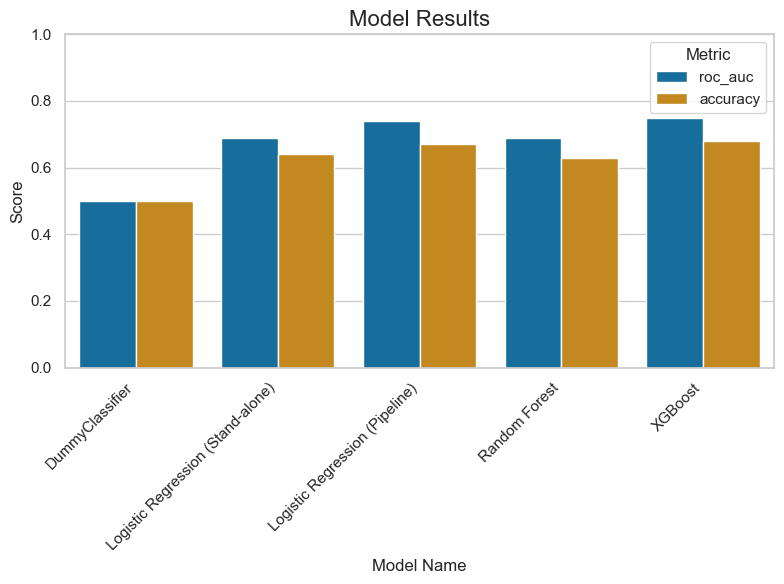

In [635]:

melted_results_df = test_results_df.melt(id_vars='name', var_name='metric', value_name='score')

# Create the bar plot
plt.figure(figsize=(8, 6))

# Plot the scores
sns.set_context("notebook", font_scale=1.0)
standard_palette = "colorblind" 

sns.barplot(data=melted_results_df, x='name', y='score', hue='metric', palette=standard_palette)
plt.xlabel('Model Name')
plt.ylabel('Score')
plt.title('Model Results', fontsize=16)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Metric')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

At the end, XGBoost performed the best followed by the Logic Regression. It could be explained by XG being better at handling non-linar data.

# Conclusion

We've reached the end of our project. The objective of this project was to address the problem **there are helpful reviews that are not voted as 'Helpful'** and identify ways to uncover helpful reviews that may not have been marked yet. In doing so we,
- extracted insights about what makes a review helpful (as identified in the Exploratory Data Analysis section)
- selected and evaluated machine learning tools that would address the problem, leveraging text analysis.

This is just a potential avenue to adres the problem and there could be a lot of opportunities to expand or start initiatives influenced by the work here. 


**Next Steps**

Some potential next steps for this project could include:
- Injesting a longer time span of reviews
- Consider other languages besides English
- Joining review data with available product data to consider the effect of other portions of the product page. For example, as the price increases is a review more likely to be markd helpful?
- Look at data at the reviewer level - perhaps the approach to address the problem could change to identifying the reviewers who leave helpful reviewes (to keep them engaged), instead of features of the reviews (although some of this would be sensitive information)
- Recreating or improving on the AI-assisted "Customers Say" meta review
